In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,scale
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest,chi2
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score,precision_score,recall_score,precision_recall_curve,matthews_corrcoef

### Metrics

In [2]:
def pre_processing(X):
    return scale(X)

def metric_accuracy(clf, X_train, y_train, X_test, y_test):
    y_train_pred, y_test_pred = clf.predict(X_train), clf.predict(X_test)
    print('Train Accuracy:', accuracy_score(y_train, y_train_pred),'\nTest Accuracy:', accuracy_score(y_test, y_test_pred))
    
def draw_roc(y_actual, scores, title=''):
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    auroc_value = auc(fpr, tpr)

    plt.plot(fpr,tpr, label = 'AUC: '+str(round(auroc_value, 4)))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR = 1-Specificity')
    plt.ylabel("TPR = Recall = Sensitivity")
    plt.title("AUC-ROC Curve: " + title)
    plt.legend(loc = 'lower right')
    plt.savefig(title+'-ROC')
    return auroc_value
    
def metric(y_test, y_pred,scores, title=''):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity, acc, f1, precision, recall, mcc = tn/(tn + fp) ,accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred)
    
    x,metric_list = PrettyTable(), []
    
    x.field_names = ["Evaluation Metric", "Score"];
    x.add_row(["Accuracy", round(acc, 4)]); metric_list.append(["Accuracy",round(acc, 4)])
    x.add_row(["F1-score", round(f1, 4)]); metric_list.append(['F1-score',round(f1, 4)])
    x.add_row(["Precision", round(precision, 4)]); metric_list.append(['Precision', round(precision, 4)])
    x.add_row(["Recall", round(recall, 4)]); metric_list.append(["Recall", round(recall, 4)])
    x.add_row(["Specificity", round(specificity, 4)]); metric_list.append(["Specificity", round(specificity, 4)])
    x.add_row(["MCC", round(mcc, 4)]); metric_list.append(["MCC", round(mcc, 4)])
    
    auroc_value = draw_roc(y_test,scores, title)
    x.add_row(["AUROC value", round(auroc_value, 4)]); metric_list.append(["AUROC value", round(auroc_value, 4)])
    
    print(x);plt.show()
    print('--------------------------------------------------------------\n\n\n')
    return metric_list

### Data loading

In [3]:
data = pd.read_csv("../datasets/SmallDataset.csv")

In [4]:
data_X=data.iloc[:,2:].values
data_Y_names=data.iloc[:,1].values

data_X, data_Y_names=data.values[:,2:], data.values[:,1]

data_classes={'B':0, 'M':1}
data_Y=[]
for i in data_Y_names:
    data_Y.append(data_classes[i])
data_Y=np.asarray(data_Y)

data_X.shape,data_Y.shape
# data_X=data.iloc[:,0:117].values
# data_Y=data.iloc[:,117].values

((569, 30), (569,))

### Pre-Processing

In [5]:
data_X=scale(data_X)

### Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.1,random_state=20)
X_train.shape,y_train.shape,X_test.shape, y_test.shape

((512, 30), (512,), (57, 30), (57,))

### Model

In [7]:
model = AdaBoostClassifier(base_estimator=svm.SVC(probability=True))

### SVM Boosting (kernel=Linear)

SVM(kernel=Linear) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9844 |
|      F1-score     | 0.9784 |
|     Precision     | 0.9891 |
|       Recall      | 0.9679 |
|    Specificity    | 0.9938 |
|        MCC        | 0.9663 |
|    AUROC value    | 0.9958 |
+-------------------+--------+


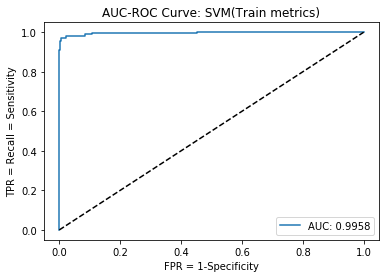

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9825 |
|      F1-score     | 0.9796 |
|     Precision     |  1.0   |
|       Recall      |  0.96  |
|    Specificity    |  1.0   |
|        MCC        | 0.9648 |
|    AUROC value    | 0.9988 |
+-------------------+--------+


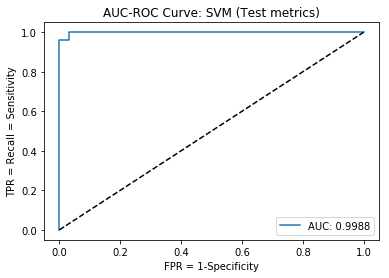

--------------------------------------------------------------





In [8]:
param_grid = {
    'base_estimator__kernel' : ['linear'],
    'base_estimator__C' : [1,10,15,20],
    'n_estimators' : [1,10,20]
}

linear_svm = GridSearchCV(model,param_grid,n_jobs=-1,cv=5)
linear_svm.fit(X_train,y_train)


linear_svm_train_pred, linear_svm_test_pred = linear_svm.predict(X_train), linear_svm.predict(X_test)
linear_svm_train_scores, linear_svm_test_scores = linear_svm.predict_proba(X_train)[:,1], linear_svm.predict_proba(X_test)[:,1]


print('SVM(kernel=Linear) classifier')
linear_svm_metric_list_train, linear_metric_list_test = metric(y_train, linear_svm_train_pred, linear_svm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, linear_svm_test_pred, linear_svm_test_scores, 'SVM (Test metrics)')

### SVM Boosting (kernel=Poly)

SVM(kernel=Poly) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9434 |
|      F1-score     | 0.9159 |
|     Precision     |  1.0   |
|       Recall      | 0.8449 |
|    Specificity    |  1.0   |
|        MCC        | 0.8807 |
|    AUROC value    | 0.9949 |
+-------------------+--------+


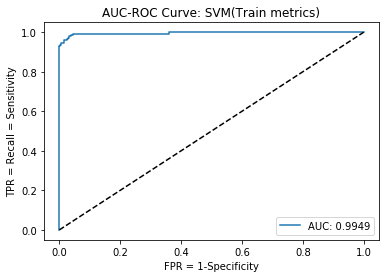

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9298 |
|      F1-score     | 0.913  |
|     Precision     |  1.0   |
|       Recall      |  0.84  |
|    Specificity    |  1.0   |
|        MCC        | 0.8641 |
|    AUROC value    |  1.0   |
+-------------------+--------+


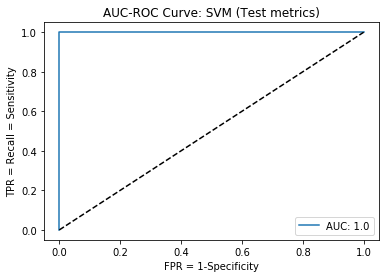

--------------------------------------------------------------





In [9]:
param_grid = {
    'base_estimator__kernel' : ['poly'],
    'base_estimator__C' : [1,10,15,20],
    'base_estimator__degree' : [0.5,1,2,3],
    'n_estimators' : [20,25]
}

poly_svm = GridSearchCV(model,param_grid,n_jobs=-1,cv=5)
poly_svm.fit(X_train,y_train)

poly_svm_train_pred, poly_svm_test_pred = poly_svm.predict(X_train), poly_svm.predict(X_test)
poly_svm_train_scores, poly_svm_test_scores = poly_svm.predict_proba(X_train)[:,1], poly_svm.predict_proba(X_test)[:,1]


print('SVM(kernel=Poly) classifier')
poly_svm_metric_list_train, poly_svm_metric_list_test = metric(y_train, poly_svm_train_pred, poly_svm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, poly_svm_test_pred, poly_svm_test_scores, 'SVM (Test metrics)')

### SVM Boosting (kernel=RBF)

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9531 |
|      F1-score     | 0.9314 |
|     Precision     |  1.0   |
|       Recall      | 0.8717 |
|    Specificity    |  1.0   |
|        MCC        | 0.901  |
|    AUROC value    | 0.9993 |
+-------------------+--------+


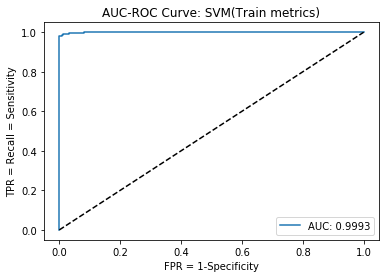

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9123 |
|      F1-score     | 0.8889 |
|     Precision     |  1.0   |
|       Recall      |  0.8   |
|    Specificity    |  1.0   |
|        MCC        | 0.8318 |
|    AUROC value    |  1.0   |
+-------------------+--------+


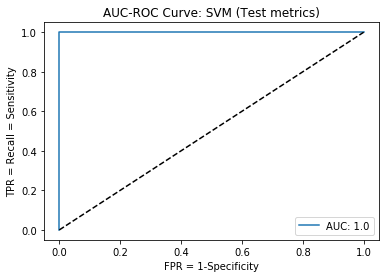

--------------------------------------------------------------





In [10]:
param_grid = {
    'base_estimator__kernel' : ['rbf'],
    'base_estimator__C' : [1,10,15,20],
    'base_estimator__gamma' : [0.0001,0.001,0.01,0.1,1],
    'n_estimators' : [20,25],
}

rbf_svm = GridSearchCV(model,param_grid,n_jobs=-1,cv=5)
rbf_svm.fit(X_train,y_train)

rbf_svm_train_pred, rbf_svm_test_pred = rbf_svm.predict(X_train), rbf_svm.predict(X_test)
rbf_svm_train_scores, rbf_svm_test_scores = rbf_svm.predict_proba(X_train)[:,1], rbf_svm.predict_proba(X_test)[:,1]


print('SVM(kernel=RBF) classifier')
rbf_svm_metric_list_train, rbf_svm_metric_list_test = metric(y_train, rbf_svm_train_pred, rbf_svm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, rbf_svm_test_pred, rbf_svm_test_scores, 'SVM (Test metrics)')